# **Assignment 1: Bird Species Classification**

My name is Thao, my student ID is 104170172. In this assignment, I used Transfer Learning for bird species classfication task on the CUB-200 dataset.


## **Import Neccessary Libraries**

In [5]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path

## **Data Preprocessing**

**Dataset Information**

The dataset for this project is from **Caltech-UCSD Birds 200 (CUB-200)**, which contains images of 200 bird species primarily from North America. There are 4,829 images available for training.

```
dataset/
    train/
        Black_footed_Albatross_0004_2731401028.jpg
        Black_footed_Albatross_0008_1384283201.jpg
        ...
    test/
        0000.jpg
        0001.jpg
        ...
    train.csv
    test.csv
```

### **Basic steps related to Dataset**

In [6]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# saving paths will be used

root_dir = "/content/drive/MyDrive/Asm1_BirdSpeciesClassification/dataset/"

train_dir = os.path.join(root_dir,'Train')
test_dir = os.path.join(root_dir,'Test')

train_csv_file = os.path.join(root_dir,'train.txt')
test_csv_file = os.path.join(root_dir,'test.txt')

In [8]:
# create label map for the label id and its corresponding bird species names based on train.txt file

def create_label_map(file_path):
    label_map = {}
    with open(file_path, 'r') as f:
        for line in f:
            image_name, label_id = line.strip().split() # Split each line into image_name and label
            class_name = " ".join(image_name.split('_')[:-2]) # Extract class_name from image_name (class_name are words from the beginning of the file_name up to, but excluding, the last two elements)
            if int(label_id) not in label_map: # Check if label is already in the map, if not, add it with the class name
                label_map[int(label_id)] = class_name
    return label_map

label_map = create_label_map(train_csv_file)

print("Number of classes in train file: ", len(label_map))
print("Label Map Sample:", list(label_map.items())[:5])

Number of classes in train file:  200
Label Map Sample: [(0, 'Black footed Albatross'), (1, 'Laysan Albatross'), (2, 'Sooty Albatross'), (3, 'Groove billed Ani'), (4, 'Crested Auklet')]


In [9]:
# Create a train dataframe and a test dataframe by concatenating image file paths and labels
def create_dataframe(file_path, img_dir, label_map):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            image_name, label_id = line.strip().split()
            class_name = label_map[int(label_id)]  # Get the class_name from label_map
            full_path = os.path.join(img_dir, image_name)  # Full image path
            data.append((full_path, class_name))  # Append filepath and class_name
    return pd.DataFrame(data, columns=['filepath', 'class_name'])

# Create train_df and test_df
train_df = create_dataframe(train_csv_file, train_dir, label_map)
test_df = create_dataframe(test_csv_file, test_dir, label_map)

# Save train_df, test_df to a CSV file
train_df.to_csv(root_dir + 'train_dataframe.csv', index=False)
test_df.to_csv(root_dir + 'test_dataframe.csv', index=False)

# Display sample data from both dataframes
print("Train DataFrame Sample:")
print(train_df.head())

print("\nTest DataFrame Sample:")
print(test_df.head())

Train DataFrame Sample:
                                            filepath              class_name
0  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
1  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
2  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
3  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
4  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross

Test DataFrame Sample:
                                            filepath              class_name
0  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
1  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
2  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
3  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross
4  /content/drive/MyDrive/Asm1_BirdSpeciesClassif...  Black footed Albatross


### **Check the distribution of number of images in each bird species**

In [10]:
import statistics

# Image count for each bird species based on the DataFrame
def image_count_per_species(df):
    species_count = df['class_name'].value_counts().to_dict()  # Count images per species
    return species_count

# Count images for each species in the training and testing datasets
train_species_count = image_count_per_species(train_df)

# Find minimum, maximum, and median for the train dataset
min_species_train, min_count_train = min(train_species_count.items(), key=lambda x: x[1])
max_species_train, max_count_train = max(train_species_count.items(), key=lambda x: x[1])
median_count_train = statistics.median(train_species_count.values())

# Output for train dataset
print("Train Dataset:")
print(f"Maximum count of images in a class: {max_count_train} images (Species: {max_species_train})")
print(f"Minimum count of images in a class: {min_count_train} images (Species: {min_species_train})")
print(f"Median count of images in a class: {median_count_train} images")

Train Dataset:
Maximum count of images in a class: 31 images (Species: Song Sparrow)
Minimum count of images in a class: 16 images (Species: Spotted Catbird)
Median count of images in a class: 25.0 images


### **Data Augmentation**

chỉ cần data augmentation để tăng dữ liệu cho tập train để huẩn luyện tốt hơn thui, còn tập test ko cần

ImageDataGenerator: tạo thêm image thông qua data augmentation techniques. Lưu ý: các ảnh mới sinh ra không được lưu vào ổ cứng máy tính, mà chỉ được sinh ra tại thời điểm huấn luyện model và lưu tạm thời trong RAM. Khi kết thức quá trình training thì các ảnh đó cũng sẽ mất.
- Tham số fill_mode='nearest' chỉ ra phương pháp bù lại giá trị cho những pixcel tại các vị trí bị mất mát do quá trình biến đổi. Nearest tức là dựa vào giá trị của các pixcel xung quanh, gần nó nhất (theo một tiêu chuẩn nào đó).

Source: https://tiensu.github.io/blog/33_dataaugmentation_modelcheckpoint_cnn/

In [11]:
# Rescale all images by 1/255 & generate some data augmentation techniques during model training but does not save them to the train directory.
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

# define parameters
BATCH_SIZE = 32
image_size = (224, 224)

# Create data generators for training and testing data using a DataFrame

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filepath',
    y_col='class_name',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filepath',
    y_col='class_name',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False  # Important for evaluation to keep the order consistent
)

Found 4829 validated image filenames belonging to 200 classes.
Found 1204 validated image filenames belonging to 200 classes.


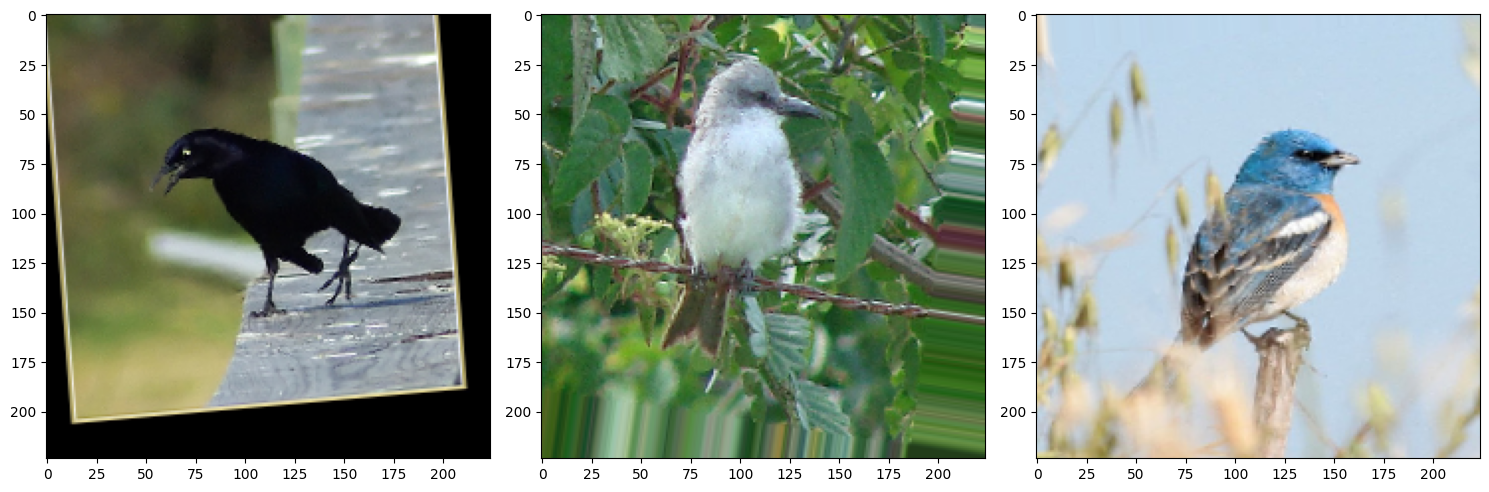

In [12]:
# visualise 3 images generate from train_generator

import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Iterate to display 3 images
for i in range(3):
    img, label = next(train_generator)
    axes[i].imshow(img[0])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot with all 3 images
plt.show()

### **Exploratory Data Analysis (EDA)**

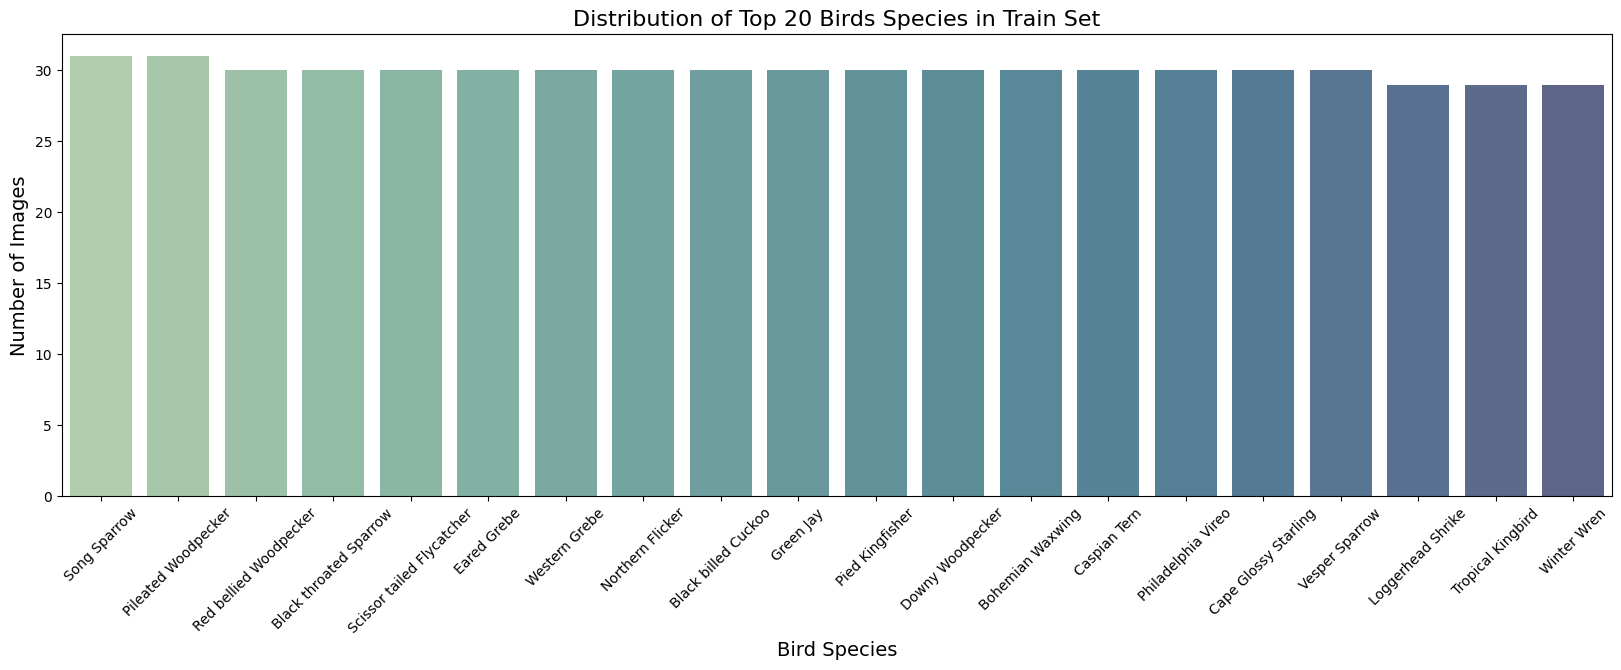

In [ ]:
import seaborn as sns

# Get the top 20 birds with most images in TRAIN
label_counts = train_df['class_name'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, legend=False, alpha=0.8, palette='crest')
plt.title('Distribution of Top 20 Birds Species in Train Set', fontsize=16)
plt.xlabel('Bird Species', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.show()

view 50 random bird species at a time

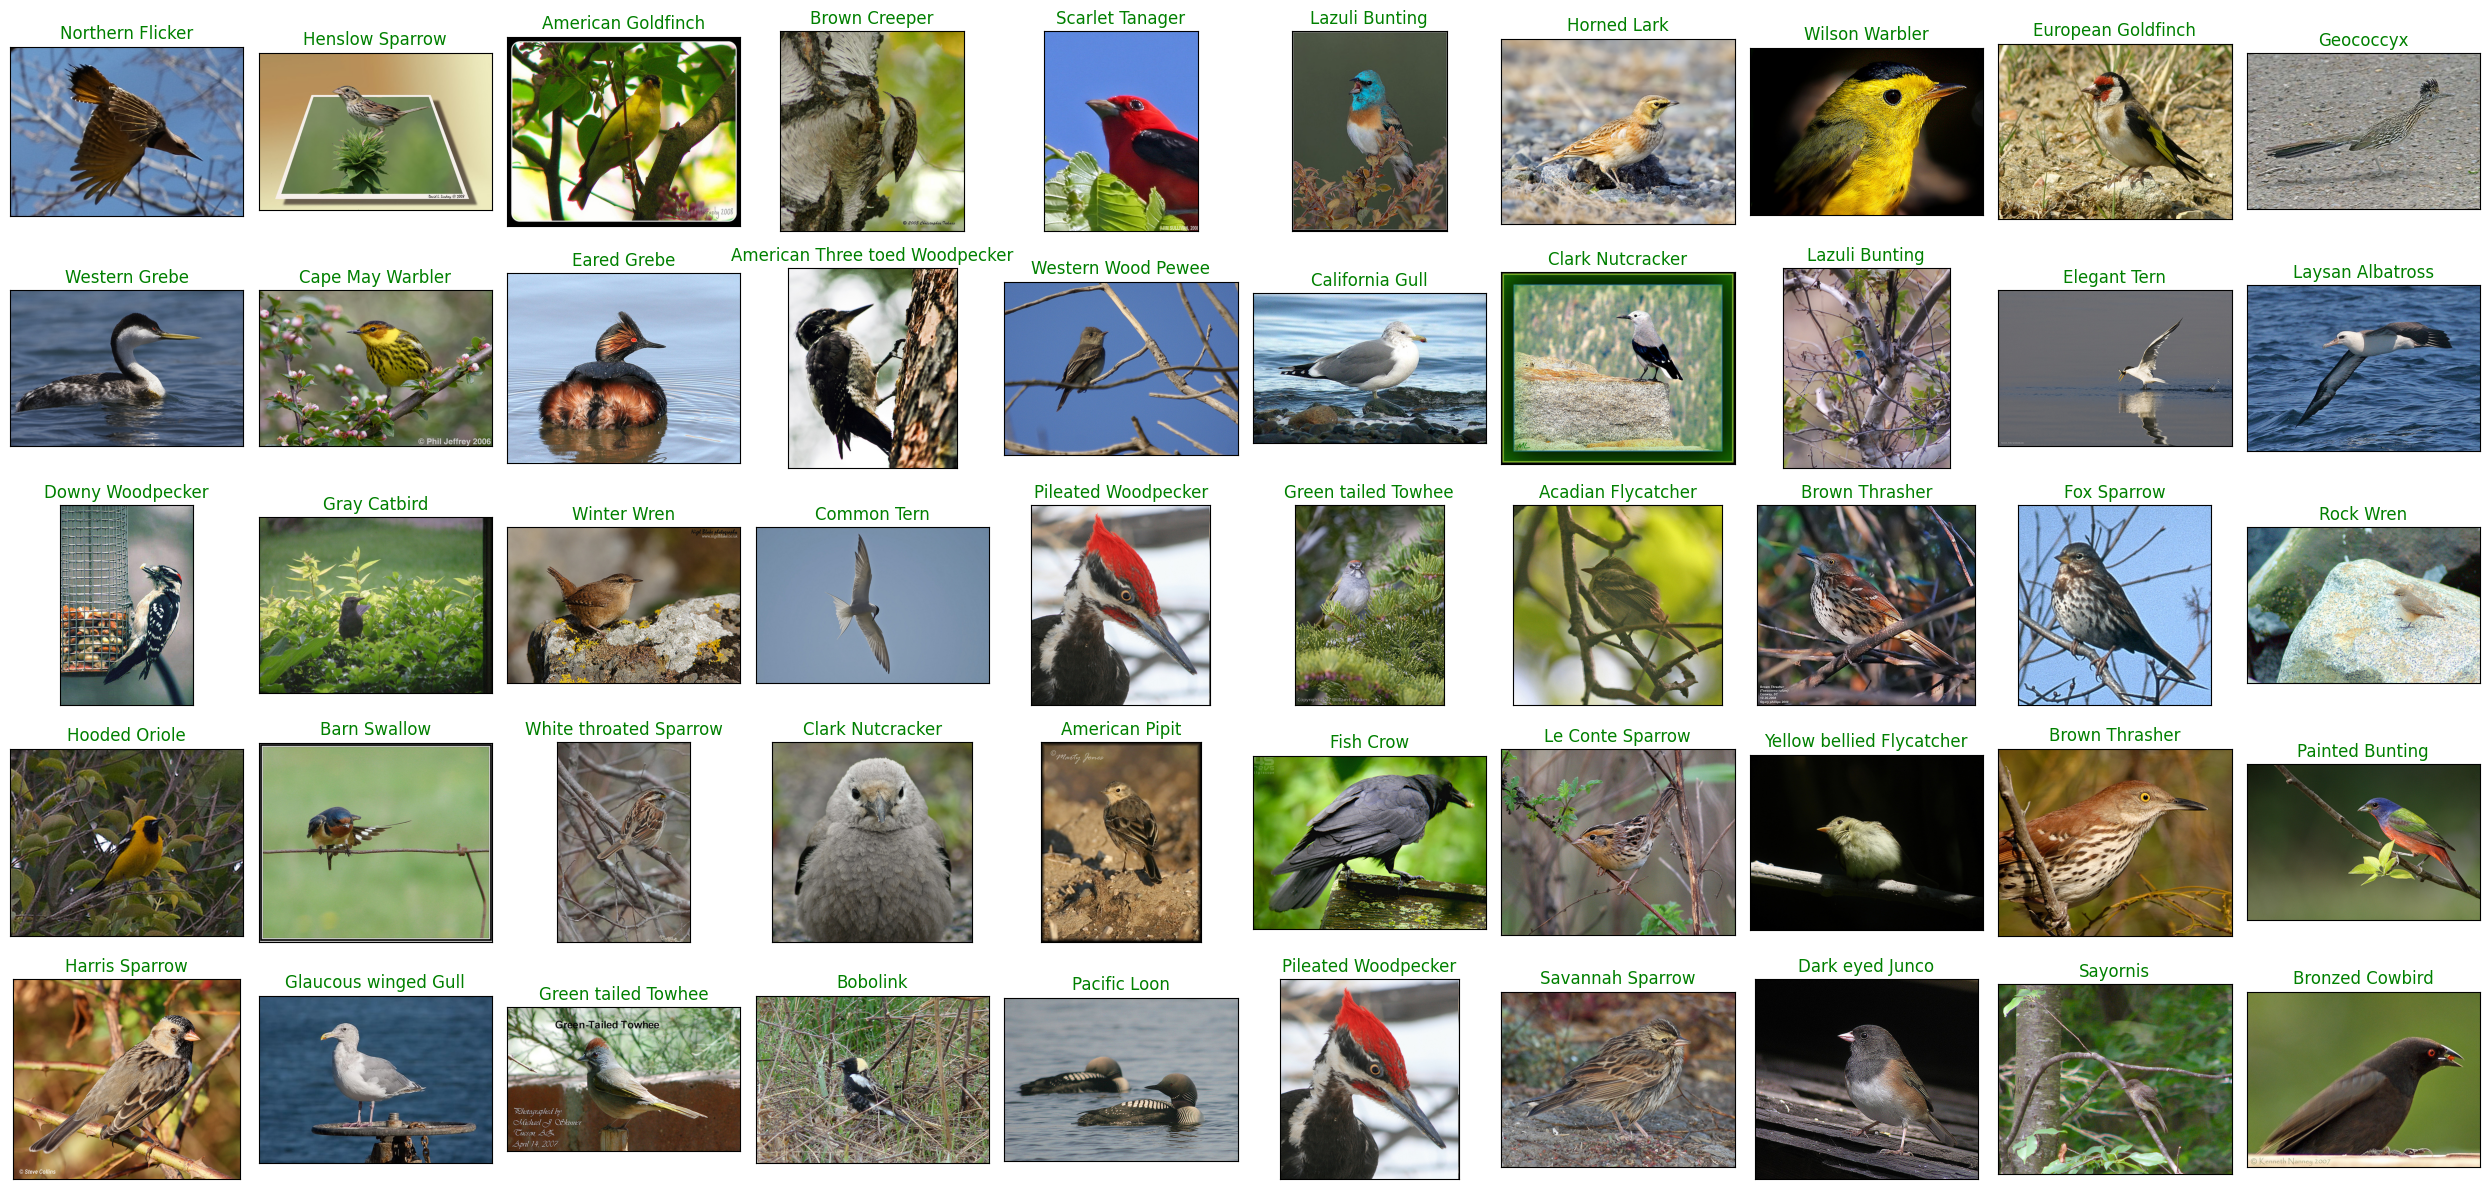

In [ ]:
# print a random set of birds to have an idea of the type of pictures we are receiving.
import numpy as np

# Display 50 pictures of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 50)
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(25, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.5, wspace=0.2)  # Adjust spacing between subplots

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.filepath[random_index[i]]))
    ax.set_title(train_df.class_name[random_index[i]], color = 'green')
plt.tight_layout()
plt.show()

## **Model Architecture**

Usint Transfer Learning with:
- VGG19
- Inception-v3
- ResNet50

### **VGG16**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

# Load VGG16 pretrained model
vgg16_model = VGG16(input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet')

# Freeze the base model
vgg16_model.trainable = False

# Build Sequential model
model_vgg16 = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),
    vgg16_model,
    layers.Flatten(),
    layers.Dense(units=1950, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=200, activation='softmax')
])

model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1950)                │      48,923,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1950)                │           7,800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │         390,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,036,238 (244.28 MB)

 Trainable params: 49,317,650 (188.13 MB)

 Non-trainable params: 14,718,588 (56.15 MB)

In [ ]:
# Compile model
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

# Fit the model
history = model_vgg16.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 2037s 13s/step - accuracy: 0.0495 - loss: 5.6813 - val_accuracy: 0.0772 - val_loss: 6.4518
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 123s 613ms/step - accuracy: 0.3167 - loss: 3.1217 - val_accuracy: 0.1503 - val_loss: 4.7569
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 141s 596ms/step - accuracy: 0.5070 - loss: 2.1107 - val_accuracy: 0.1736 - val_loss: 4.8829
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 151s 668ms/step - accuracy: 0.6324 - loss: 1.5079 - val_accuracy: 0.1944 - val_loss: 4.8720
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 132s 593ms/step - accuracy: 0.7074 - loss: 1.2171 - val_accuracy: 0.1952 - val_loss: 4.7080
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 141s 597ms/step - accuracy: 0.7606 - loss: 0.9232 - val_accuracy: 0.2350 - val_loss: 4.6147
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 604ms/step - accuracy: 0.8188 - loss: 0.7195 - val_accuracy: 0.2458 - val_loss: 4.5813
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 140s 591ms/step - accuracy: 0.8471 - loss:

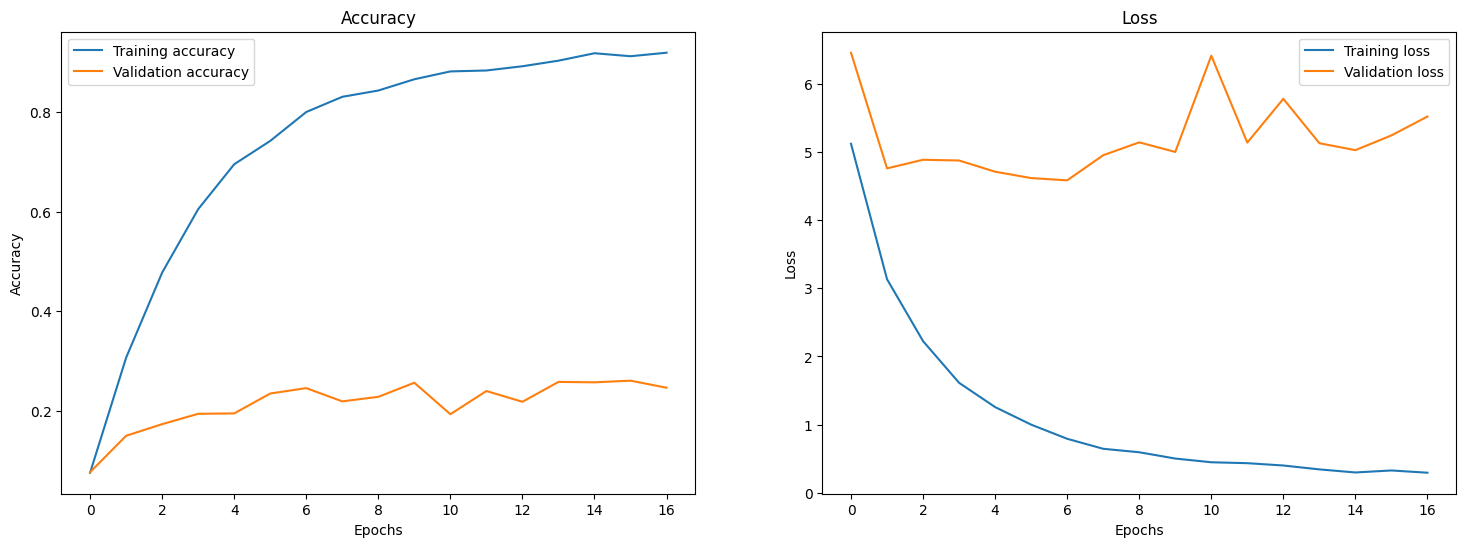

In [ ]:
# Visualise the performance

def plot_results(history):
  result = pd.DataFrame(history.history)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
  ax = ax.flatten()

  ax[0].plot(result['accuracy'], label='Training accuracy')
  ax[0].plot(result['val_accuracy'], label='Validation accuracy')
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  ax[0].set_title("Accuracy")
  ax[0].legend(loc='best')

  ax[1].plot(result['loss'], label='Training loss')
  ax[1].plot(result['val_loss'], label='Validation loss')
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")
  ax[1].set_title("Loss")
  ax[1].legend(loc='best')

  plt.show()

plot_results(history)

In [ ]:
model_vgg16.evaluate(test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.2486 - loss: 5.0747


[5.516648769378662, 0.24667774140834808]

In [ ]:
model_vgg16.save('model_vgg16.h5')

### **Inception-v3**

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model
inceptionv3_model = InceptionV3(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

# Freeze the pre-trained model
inceptionv3_model.trainable = False

# Create a Sequential model and add layers
model_inceptionv3 = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),
    inceptionv3_model,
    layers.Flatten(),
    layers.Dense(units=1950, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=200, activation='softmax'),
])

model_inceptionv3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1950)                │      99,841,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 1950)                │           7,800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 200)                 │         390,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,042,734 (465.56 MB)

 Trainable params: 100,236,050 (382.37 MB)

 Non-trainable params: 21,806,684 (83.19 MB)

In [ ]:
# Compile the model
model_inceptionv3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 128s 716ms/step - accuracy: 0.1319 - loss: 4.9594 - val_accuracy: 0.2733 - val_loss: 3.7178
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 114s 581ms/step - accuracy: 0.4280 - loss: 2.2945 - val_accuracy: 0.3173 - val_loss: 3.2712
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 597ms/step - accuracy: 0.5567 - loss: 1.6482 - val_accuracy: 0.3696 - val_loss: 3.0300
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 599ms/step - accuracy: 0.6736 - loss: 1.1991 - val_accuracy: 0.4037 - val_loss: 2.8251
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 91s 578ms/step - accuracy: 0.7333 - loss: 0.9628 - val_accuracy: 0.4078 - val_loss: 3.0078
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 91s 576ms/step - accuracy: 0.7549 - loss: 0.8194 - val_accuracy: 0.4053 - val_loss: 2.7175
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 592ms/step - accuracy: 0.7970 - loss: 0.6896 - val_accuracy: 0.4103 - val_loss: 2.9200
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 140s 579ms/step - accuracy: 0.8

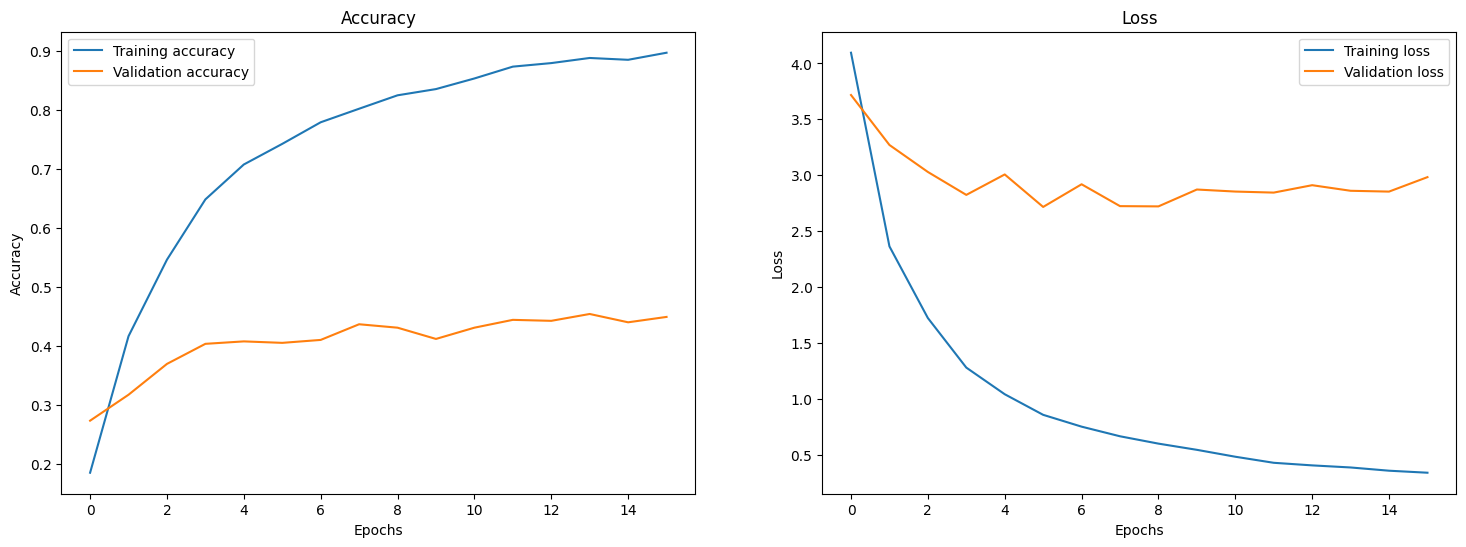

In [ ]:
plot_results(history_inceptionv3)

In [ ]:
model_inceptionv3.evaluate(test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.4992 - loss: 2.6623


[2.9838027954101562, 0.4493355453014374]

In [ ]:
model_inceptionv3.save('model_inceptionv3.h5')

### **ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the InceptionV3 model
resnet50_model = ResNet50(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')

# Freeze the pre-trained model
resnet50_model.trainable = False

# Create a Sequential model and add layers
model_resnet50 = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),
    resnet50_model,
    layers.Flatten(),
    layers.Dense(units=1950, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=200, activation='softmax'),
])

model_resnet50.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1950)                │     195,688,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1950)                │           7,800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │         390,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,674,062 (837.99 MB)

 Trainable params: 196,082,450 (748.00 MB)

 Non-trainable params: 23,591,612 (89.99 MB)

In [ ]:
# Compile the model
model_resnet50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 1908s 12s/step - accuracy: 0.0141 - loss: 5.7914 - val_accuracy: 0.0050 - val_loss: 22.7489
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 136s 595ms/step - accuracy: 0.0471 - loss: 5.1346 - val_accuracy: 0.0125 - val_loss: 11.7896
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 612ms/step - accuracy: 0.0571 - loss: 4.8714 - val_accuracy: 0.0133 - val_loss: 19.6498
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 139s 593ms/step - accuracy: 0.0830 - loss: 4.6372 - val_accuracy: 0.0183 - val_loss: 8.7279
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 588ms/step - accuracy: 0.1019 - loss: 4.4432 - val_accuracy: 0.0083 - val_loss: 65.4697
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 598ms/step - accuracy: 0.1077 - loss: 4.3277 - val_accuracy: 0.0274 - val_loss: 6.9488
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 92s 587ms/step - accuracy: 0.1263 - loss: 4.1811 - val_accuracy: 0.0465 - val_loss: 7.3154
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 587ms/step - accuracy: 0.1492 - los

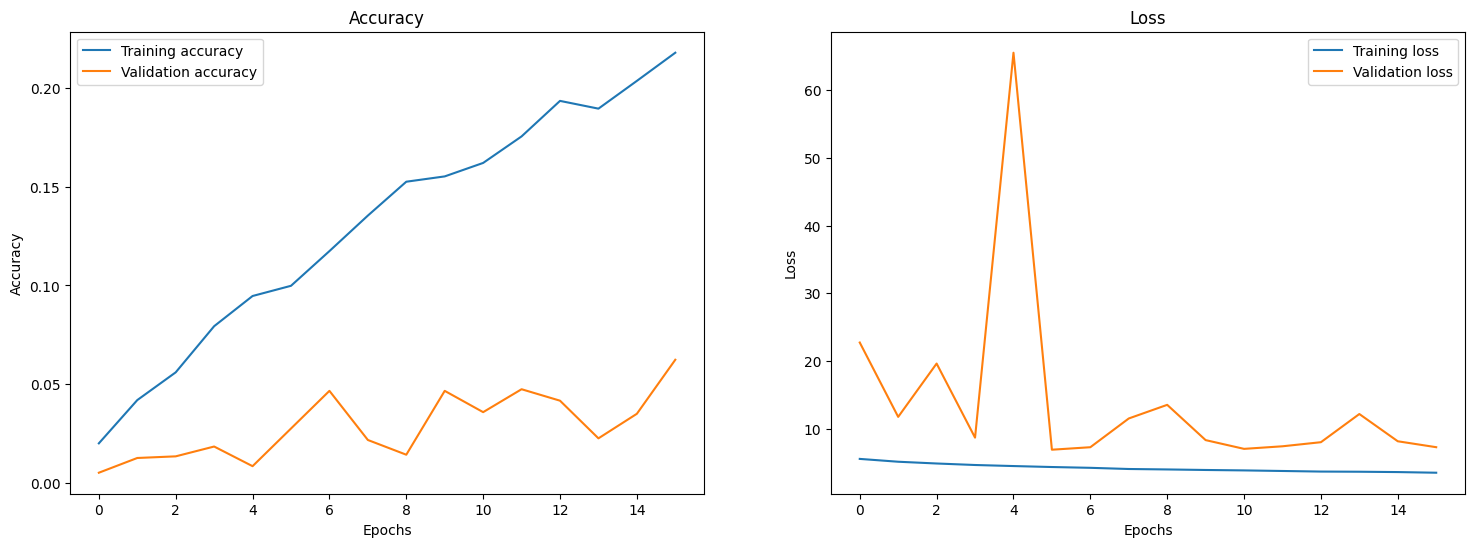

In [ ]:
plot_results(history_resnet50)

In [ ]:
model_resnet50.evaluate(test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.0563 - loss: 7.4584


[7.3187737464904785, 0.06229235976934433]

In [ ]:
model_resnet50.save('model_resnet50.h5')

## **Evaluation**

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Function to evaluate and report metrics
def evaluate_and_report(model, generator, model_name):

    print(f"--- Evaluating {model_name} ---")

    # Get predictions and true labels
    predictions = model.predict(generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = generator.classes

    # Top-1 Accuracy
    top1_accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Top-1 Accuracy: {top1_accuracy:.4f}")

    # Average Accuracy per Class (using recall)
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    class_accuracies = [report[str(i)]['recall'] for i in range(len(report) - 3)]  # Exclude non-class keys
    avg_accuracy = np.mean(class_accuracies)
    print(f"Average Accuracy per Class: {avg_accuracy:.4f}")

    # Other metrics (from classification_report)
    print(classification_report(true_labels, predicted_labels))

**Evaluate and report for each model**

In [ ]:
evaluate_and_report(model_vgg16, test_generator, "VGG16")

In [27]:
evaluate_and_report(model_inceptionv3, test_generator, "Inception-v3")

--- Evaluating Inception-v3 ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step
Top-1 Accuracy: 0.4493
Average Accuracy per Class: 0.4423
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.33      0.40      0.36         5
           2       0.38      0.60      0.46         5
           3       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         6
           5       0.43      0.50      0.46         6
           6       0.60      0.60      0.60         5
           7       0.20      0.43      0.27         7
           8       0.33      0.43      0.38         7
           9       1.00      0.20      0.33         5
          10       0.00      0.00      0.00         5
          11       0.17      0.20      0.18         5
          12       0.26      0.83      0.40         6
          13       0.25      0.50      0.33         6
          14       0.50      0.14      0.22         7
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
evaluate_and_report(model_resnet50, test_generator, "ResNet50")

--- Evaluating ResNet50 ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step
Top-1 Accuracy: 0.0623
Average Accuracy per Class: 0.0574
              precision    recall  f1-score   support

           0       0.02      0.29      0.04         7
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.04      0.20      0.07         5
           7       0.00      0.00      0.00         7
           8       0.20      0.29      0.24         7
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         7
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m